In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import numpy

In [10]:
base_dir = "./" # You may need to change this, depending on where your datasets folder is
dataset_dir = os.path.join(base_dir, "")
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

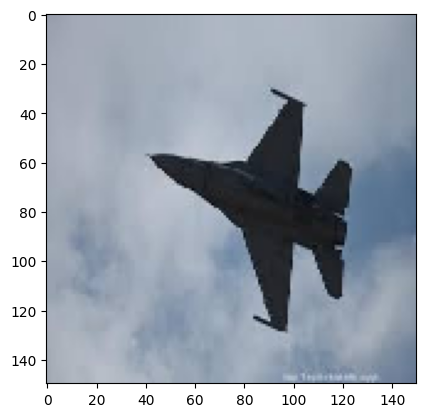

In [11]:
train_falcon_dir = os.path.join(train_dir, "falcon")
filenames = [os.path.join(train_falcon_dir, filename) for filename in os.listdir(train_falcon_dir)]

idx = 20
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)


In [12]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="binary", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="binary", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="binary", image_size=(224, 224))

Found 100 files belonging to 2 classes.


2023-02-03 00:23:09.249013: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-03 00:23:09.249451: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 00:23:09.249521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (akagi): /proc/driver/nvidia/version does not exist
2023-02-03 00:23:09.253122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 50 files belonging to 2 classes.
Found 50 files belonging to 2 classes.


In [13]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [14]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = resnet50_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [15]:
convnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                         

In [16]:
convnet_history = convnet.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-03 00:23:47.270799: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 807469056 exceeds 10% of free system memory.
2023-02-03 00:23:55.109538: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 403734528 exceeds 10% of free system memory.
2023-02-03 00:23:55.109650: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 807469056 exceeds 10% of free system memory.
2023-02-03 00:23:57.442134: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 807469056 exceeds 10% of free system memory.
2023-02-03 00:24:04.381949: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 403734528 exceeds 10% of free system memory.


<AxesSubplot: >

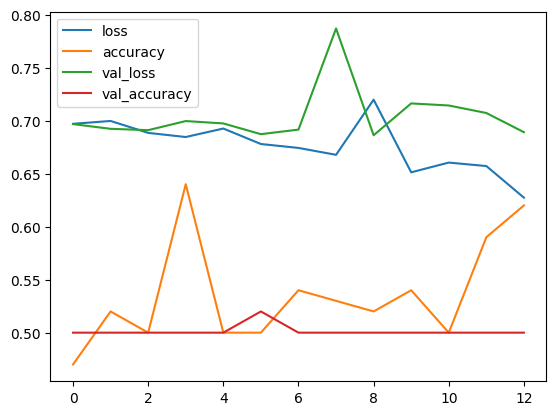

In [17]:
pd.DataFrame(convnet_history.history).plot()

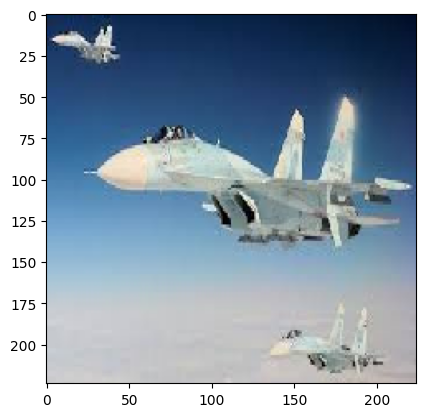

In [19]:
test_flanker_dir = os.path.join(test_dir, "flanker")
filenames = [os.path.join(test_flanker_dir, filename) for filename in os.listdir(test_flanker_dir)]

idx = 20
some_example = load_img(filenames[idx], target_size=(224, 224))

plt.imshow(some_example)


In [21]:
test_loss, test_acc = convnet.evaluate(test_dataset)

2/2 [==============================] - 5s 2s/step - loss: 0.6815 - accuracy: 0.5000
